# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist

%jsroot on
# %matplotlib qt
%matplotlib inline

In [2]:
sys.path.append('../python/')
from filterMethods import *
from timeMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
useHistograms = True

checkFiles = False

splitDataIntoFiles = True # for big data

saveData_hits    = True
saveData_primary = True
loadData_hits    = False
loadData_primary = False
saveData_hits_path    = 'data/MLdata/MLtrainData_hits.pkl'
saveData_primary_path = 'data/MLdata/MLtrainData_primary.pkl'

In [5]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events_0cmFOVL_+-1.21randPosNoSteps_randDir.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events_20cmFOVL.root'
# fileName = '../build/calibration.root'
# fileName = '../build/event100.root'
# fileNames = [
#     '../build/event_1.root',
#     '../build/event_2.root'
# ]

if not loadData_hits:
    histDir = '/photoSensor_hits_histograms'
    treeName = 'photoSensor_hits;1'
    minInitialPositions = 20
    minWalls = 2

    # fileNames = ['../build/multievent_{}.root'.format(i) for i in range(75)] # 100
    # fileNames = [fileName for fileName in tqdm.tqdm(fileNames) if len(get_photosensor_hits_position_initial(fileName, treeName)) >= minInitialPositions]
    # fileNames = [fileName for fileName in tqdm.tqdm(fileNames) if len(np.unique([x[1] for x in get_photosensor_hits_photosensor_wall(fileName, treeName)])) >= minWalls]

    fileNames = ['../runs/MLtrainData/multievent_{}.root'.format(i) for i in tqdm.tqdm(range(1138))] # 1138

    if checkFiles:
        sizes = [get_histogram_sizes(fileName, histDir) for fileName in tqdm.tqdm(fileNames)]
        if len(np.unique(np.array(sizes).reshape(-1, 2))) > 1:
            raise Exception('Different sizes:', np.unique(sizes))
        fileNames = [fileName for fileName in tqdm.tqdm(fileNames) if get_histogram_nHits_total(fileName, histDir) >= minInitialPositions]

    print('len(fileNames):', len(fileNames))

    # for fileName in tqdm.tqdm(fileNames)
        # print(get_histogram_names    (fileName, histDir))
        # print(get_histogram_titles   (fileName, histDir))
        # print(get_histogram_positions(fileName, histDir))
        # print(get_histogram_walls    (fileName, histDir))
        # print()


100%|██████████| 1138/1138 [00:00<00:00, 3142276.47it/s]

len(fileNames): 1138


In [6]:
treeName = 'photoSensor_hits;1'
dfs_hits = []

if loadData_hits:
    with open(saveData_hits_path, 'rb') as f:
        dfs_hits = pkl.load(f)
    print('df_hits length:', len(dfs_hits))
    print('df_hits[0].head():\n', dfs_hits[0].head())
else:
    for fileName in tqdm.tqdm(fileNames):
        df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'sensor_wall', 'relativePosition_binned', 'relativePosition_nBin'])
        if useHistograms:
            photosensor_IDs, photosensor_directions, photosensor_positions, photosensor_walls, position_relative_binned, position_relative_nBin = get_histogram_hits_tuple(fileName, histDir, True)
            df_hits['sensor_name'            ] = photosensor_IDs
            df_hits['sensor_direction'       ] = photosensor_directions
            df_hits['sensor_position'        ] = photosensor_positions
            df_hits['sensor_wall'            ] = photosensor_walls
            df_hits['relativePosition_binned'] = position_relative_binned
            df_hits['relativePosition_nBin'  ] = position_relative_nBin
        else:
            df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName, histDir, verbose=False)
            # df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName, histDir, verbose=False)
            df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir, verbose=False)
            # df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir, verbose=False)
            # df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName,          verbose=False)
        dfs_hits.append(df_hits)
    print('df_hits length:', len(dfs_hits))
    print('df_hits[0].head():\n', dfs_hits[0].head())

    if saveData_hits:
        with open(saveData_hits_path, 'wb') as f:
            pkl.dump(dfs_hits, f)
        print('Data saved to', saveData_hits_path)

 13%|█▎        | 150/1138 [05:15<34:37,  2.10s/it] 


KeyboardInterrupt: 

In [ ]:
treeName = 'primary;1'
dfs_primary = []

if loadData_primary:
    with open(saveData_primary_path, 'rb') as f:
        dfs_primary = pkl.load(f)
    print('df_primary length:', len(dfs_primary))
    print('df_primary[0].head():\n', dfs_primary[0].head())
else:
    for fileName in tqdm.tqdm(fileNames):
        df_primary = pd.DataFrame(columns=['position', 'pdg'])
        df_primary['position' ] = get_primary_position(fileName, treeName)
        df_primary['pdg'      ] = get_primary_pdg     (fileName, treeName)
        df_primary = df_primary[df_primary['pdg'] == 13] # muon
        df_primary = df_primary[df_primary['position'].apply(lambda x:
            x[0] > -DETECTOR_SIZE_MM[0]/2 and x[0] < DETECTOR_SIZE_MM[0]/2 and
            x[1] > -DETECTOR_SIZE_MM[1]/2 and x[1] < DETECTOR_SIZE_MM[1]/2 and
            x[2] > -DETECTOR_SIZE_MM[2]/2 and x[2] < DETECTOR_SIZE_MM[2]/2
        )]
        dfs_primary.append(df_primary)
    print('df_primary length:', len(dfs_primary))
    print('df_primary[0].head():\n', dfs_primary[0].head())

    if saveData_primary:
        with open(saveData_primary_path, 'wb') as f:
            pkl.dump(dfs_primary, f)
        print('Data saved to', saveData_primary_path)

100%|██████████| 3/3 [00:00<00:00, 40.93it/s]

df_primary length: 3
df_primary[0].head():
                                             position  pdg
0  (-86.26307828444254, 451.1131641000807, 812.89...   13
1  (-86.29582587532713, 450.5539990621913, 812.75...   13
2  (-86.32926652713361, 449.9946140973119, 812.61...   13
3  (-86.36331401096261, 449.43518004193965, 812.4...   13
4  (-86.39892018162553, 448.87597406971213, 812.3...   13
Data saved to data/MLdata/MLtrainData_primary.pkl


In [ ]:
if len(dfs_primary) != len(dfs_hits):
    raise Exception('len(dfs_primary) != len(dfs_hits)')

# Filter Hits

In [9]:
search_radius = 0
search_number = 0

if search_radius > 0 or search_number > 0:
    for i in tqdm.tqdm(range(len(dfs_hits))):
        dfs_hits[i] = filter_hits(dfs_hits[i], radius=search_radius, number=search_number)

# Basic Hit Reco

In [10]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
for i in tqdm.tqdm(range(len(dfs_hits))):
    dfs_hits[i] = make_r(dfs_hits[i])
    dfs_hits[i] = filter_r(dfs_hits[i], Y_LIM)
    dfs_hits[i] = make_theta(dfs_hits[i], rToTheta)
    dfs_hits[i] = make_phi(dfs_hits[i])
    dfs_hits[i] = make_reconstructedVector_direction(dfs_hits[i])
    if 'initialPosition' in dfs_hits[i].columns:
        dfs_hits[i] = make_relativeVector(dfs_hits[i])

  0%|          | 0/3 [00:00<?, ?it/s]

# Plotting Methods

In [ ]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Make or Load Grid

In [ ]:
gridSize = (20, 20, 20)
makeErrors = False
save = False
savePlots = False
load = False
useWalls = False
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 20x20x20_multievent_2_noErrors


# Data

In [ ]:
gridSize_input = gridSize
gridSize_output = np.array([20, 20, 20]) # 92, 92, 92

X_size = (len(dfs_hits),) + gridSize_input + (6,)
Y_size = (len(dfs_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2])

X = np.zeros((len(dfs_hits),) + gridSize_input + (6,))
Y = np.zeros((len(dfs_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2]))

for i, (df_hits, df_primary) in tqdm.tqdm(enumerate(zip(dfs_hits, dfs_primary))):
    X[i], grid_ind, grid_pos = make_voxelGrid(
        df_hits,
        shape=gridSize_input,
        detectorDimensions=DETECTOR_SIZE_MM,
        sensorPositions=np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
        recoDirections=np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
        hitWeights=[1 for i in range(len(df_hits))],
        make_errors=makeErrors,
        useWalls=useWalls,
        sensorWalls=df_hits['sensor_wall'].to_numpy(),
        wallOperation=expNWalls,
        returnWalls=True)
    Y[i] = make_voxelGrid_truth(
        # np.array(df_hits['initialPosition'].to_list()),
        np.array(df_primary['position'].to_list()),
        shape=gridSize_output,
        detectorDimensions=DETECTOR_SIZE_MM,
        makeErrors=False)[0]*10

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)
print()
print('grid_ind.shape:', grid_ind.shape)
print('grid_pos.shape:', grid_pos.shape)

3it [00:29,  9.77s/it]

X.shape: (3, 20, 20, 20, 6)
Y.shape: (3, 20, 20, 20)

grid_ind.shape: (8000, 3)
grid_pos.shape: (8000, 3)


In [ ]:
nTest = 20
np.random.seed(42)
testIndices = np.random.choice(len(dfs_hits), nTest, replace=False)

X_train = np.delete(X, testIndices, axis=0)
Y_train = np.delete(Y, testIndices, axis=0)
X_test = X[testIndices]
Y_test = Y[testIndices]

X_train_indices = np.delete(np.arange(len(dfs_hits)), testIndices)
Y_train_indices = np.delete(np.arange(len(dfs_hits)), testIndices)
X_test_indices = np.array(testIndices)
Y_test_indices = np.array(testIndices)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)
print()
print('X_train_indices:', X_train_indices)
print('X_test_indices:', X_test_indices)

X_train.shape: (3, 20, 20, 20, 6)
Y_train.shape: (3, 20, 20, 20)
X_test.shape: (0, 20, 20, 20, 6)
Y_test.shape: (0, 20, 20, 20)

X_train_indices: [0 1 2]
X_test_indices: []


In [ ]:
# %matplotlib qt
%matplotlib inline

indices = [46, 51, 52]
# indices = X_train_indices

plots = [False, False, False]
format = 'pdf'
resolution = 300

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize[2] + 1)

yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

# globalColorNorm = cm.colors.Normalize(vmin=0, vmax=np.max([X_train[ind].sum(axis=-1).max()]))
globalColorNorm = cm.colors.Normalize(vmin=0, vmax=25)

alpha_empty = 0.45
alpha_filled = 0.45
alpha_true = 0.3

##################################################################################################
##################################################################################################
##################################################################################################

for ind in tqdm.tqdm(indices):
    colors = cm.viridis(globalColorNorm(X_train[ind].sum(axis=-1)))

##################################################################################################
##################################################################################################
##################################################################################################

    if plots[0]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax.voxels(xEdges,
                yEdges,
                zEdges,
                X_train[ind].sum(axis=-1),
                facecolors=colors,
                edgecolors=np.clip(colors*2-0.5, 0, 1),
                linewidth=0.5,
                alpha=alpha_filled)

        ax.voxels(xEdges,
                yEdges,
                zEdges,
                np.ones(gridSize),
                facecolors='lightgray',
                edgecolor='gray',
                linewidth=0.5,
                alpha=alpha_empty)
        
        cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=ax, shrink=0.6)

        ax.set_axis_off()
        ax.set_aspect('equal')
        plt.savefig('../figures/voxelGrid_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[1]:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='3d')

        nonZeroInd = np.where(Y_train[ind].flatten() > 0)
        ax.voxels(xEdges,
                yEdges,
                zEdges,
                Y_train[ind],
                facecolors='r',
                edgecolors='k',
                linewidth=0.5,
                alpha=alpha_true)

        ax.voxels(xEdges,
                yEdges,
                zEdges,
                np.ones(gridSize),
                facecolors='lightgray',
                edgecolor='gray',
                linewidth=0.5,
                alpha=alpha_empty)

        primary = np.array(dfs_primary[X_train_indices[ind]]['position'].to_list())
        ax.scatter(primary[:,0], primary[:,1], primary[:,2], c='b', s=10)

        ax.set_axis_off()
        ax.set_aspect('equal')
        plt.savefig('../figures/voxelGrid_truth_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[2]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax.voxels(xEdges,
                yEdges,
                zEdges,
                X_train[ind].sum(axis=-1),
                facecolors=colors,
                edgecolors=np.clip(colors*2-0.5, 0, 1),
                linewidth=0.5,
                alpha=alpha_filled)

        nonZeroInd = np.where(Y_train[ind].flatten() > 0)
        ax.voxels(xEdges,
                yEdges,
                zEdges,
                Y_train[ind],
                facecolors='r',
                edgecolors='k',
                linewidth=0.5,
                alpha=alpha_true)

        ax.voxels(xEdges,
                yEdges,
                zEdges,
                np.ones(gridSize),
                facecolors='lightgray',
                edgecolor='gray',
                linewidth=0.5,
                alpha=alpha_empty)
        
        cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=ax, shrink=0.6)

        ax.set_axis_off()
        ax.set_aspect('equal')
        plt.savefig('../figures/voxelGrid_both_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]


IndexError: index 46 is out of bounds for axis 0 with size 3

# Model

In [ ]:
input_data = tf.keras.layers.Input(shape=X_size[1:])
summed_data = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1))(input_data)

dropoutRate = 0.2

conv_1_1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='valid')(input_data)
conv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_1)
maxPool_1_1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_1_drop)
conv_1_2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='valid')(maxPool_1_1)
conv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_2)
maxPool_1_2 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_2_drop)

mlp_conv = tf.keras.layers.Flatten()(maxPool_1_2)
mlp_1 = tf.keras.layers.Dense(256, activation='relu')(mlp_conv)
mpl_1_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_1)
mlp_2 = tf.keras.layers.Dense(16**3, activation='relu')(mpl_1_drop)
mlp_2_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_2)
mlp_res = tf.keras.layers.Reshape((16, 16, 16, 1))(mlp_2_drop)

deconv_1_1 = tf.keras.layers.Conv3DTranspose(64, (3, 3, 3), activation='relu', padding='valid')(mlp_res)
deconv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_1)
deconv_1_2 = tf.keras.layers.Conv3DTranspose(32, (3, 3, 3), activation='relu', padding='valid')(deconv_1_1_drop)
deconv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_2)

output = tf.keras.layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(deconv_1_2_drop)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [ ]:
def sparseLoss(true, pred): 
    epsilon = 1 # 1e-7
    mask = tf.greater(true, epsilon)
    mask = tf.dtypes.cast(mask, tf.float32)

    loss_inMask = tf.square(tf.subtract(true, pred))
    loss_inMask = tf.multiply(loss_inMask, mask)
    loss_inMask /= tf.reduce_sum(mask)

    loss_outMask = tf.square(tf.subtract(true, pred))
    loss_outMask = tf.multiply(loss_outMask, 1-mask)
    loss_outMask /= tf.reduce_sum(1-mask)

    # return tf.reduce_mean(loss)
    return tf.reduce_sum(loss_inMask) + tf.reduce_sum(loss_outMask)

def distancesFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    if type(true) == np.ndarray:
        true = tf.convert_to_tensor(true, dtype=tf.float32)
    if type(pred) == np.ndarray:
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    pred = tf.cast(pred, tf.float32)
    true = tf.cast(true, tf.float32)
    deltaEps = tf.constant(deltaEps, dtype=tf.float32)
    eps = tf.constant(eps, dtype=tf.float32)

    if optimize:
        # while tf.where(tf.greater(pred, eps)).numpy().size < minEntries and eps > 0:
        while tf.size(tf.where(tf.greater(pred, eps))) < minEntries and eps > 0.0:
            # print(tf.where(tf.greater(pred, eps)).numpy().size)
            eps -= deltaEps

    mask = tf.cast(tf.greater(pred, eps), tf.float32)
    pred = pred * mask

    true = tf.reshape(true, (-1, 1))
    pred = tf.reshape(pred, (-1, 1))

    pred_ind = tf.where(tf.greater(pred, 0))
    true_ind = tf.where(tf.greater(true, 0))

    pred_ind = pred_ind[:, 0]
    true_ind = true_ind[:, 0]

    posTensor = tf.convert_to_tensor(grid_pos, dtype=tf.float32)

    pred_pos = tf.gather(posTensor, pred_ind)
    true_pos = tf.gather(posTensor, true_ind)

    pred_pos = tf.reshape(pred_pos, (-1, 3))
    true_pos = tf.reshape(true_pos, (-1, 3))

    pred_pos = tf.expand_dims(pred_pos, 1)
    true_pos = tf.expand_dims(true_pos, 0)

    distances = tf.norm(pred_pos - true_pos, axis=-1)
    minDistances = tf.reduce_min(distances, axis=1)

    return minDistances

def distancesFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return distancesFromRecoToTrue(pred, true, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)

def meanDistanceFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distancesFromRecoToTrue(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def meanDistanceFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distancesFromTrueToReco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def meanAndDistancesFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distancesFromRecoToTrue(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

def meanAndDistancesFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distancesFromTrueToReco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

def totalLoss(true, pred, eps=15, optimize=True, minEntries=15, deltaEps=0.1, alpha=0.10, beta=0.10):
    return sparseLoss(true, pred) \
         + alpha * meanDistanceFromRecoToTrue(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps) \
         + beta  * meanDistanceFromTrueToReco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)

In [ ]:
custom_learning_rate = 0.0001  # Change this to your desired learning rate (default = 0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
# optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer, loss=sparseLoss,
              metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity',
                       sparseLoss, totalLoss,
                       meanDistanceFromRecoToTrue, meanDistanceFromTrueToReco])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 20, 20, 6)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 18, 18, 18, 32)    5216      
                                                                 
 dropout_12 (Dropout)        (None, 18, 18, 18, 32)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 9, 9, 32)      0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 7, 7, 64)       55360     
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 7, 64)       0         
                                                           

In [ ]:
useEarlyStopping = False
k = 5
nEpochs = 30
batchSize = 1
patience = 20

kFold = KFold(n_splits=k, shuffle=True)

histories = []
for i, (train_index, val_index) in tqdm.tqdm(enumerate(kFold.split(X_train))):
    X_train_k, X_val_k = X_train[train_index], X_train[val_index]
    Y_train_k, Y_val_k = Y_train[train_index], Y_train[val_index]

    if useEarlyStopping:
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k), callbacks=[early_stopping_callback]))
    else:
        histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k)))

0it [00:00, ?it/s]

Epoch 1/30
132/132 [==============================] - 5s 31ms/step - loss: 79.0715 - accuracy: 0.6822 - mean_squared_error: 5.4269 - mean_absolute_error: 1.1251 - mean_absolute_percentage_error: 1110664064.0000 - mean_squared_logarithmic_error: 0.6389 - cosine_similarity: 0.0078 - sparseLoss: 79.0715 - totalLoss: 169.1789 - meanDistanceFromRecoToTrue: nan - meanDistanceFromTrueToReco: 1.0943 - val_loss: 69.5531 - val_accuracy: 0.5948 - val_mean_squared_error: 2.1185 - val_mean_absolute_error: 0.8997 - val_mean_absolute_percentage_error: 884559552.0000 - val_mean_squared_logarithmic_error: 0.4792 - val_cosine_similarity: 0.0098 - val_sparseLoss: 69.5531 - val_totalLoss: 140.3521 - val_meanDistanceFromRecoToTrue: nan - val_meanDistanceFromTrueToReco: 0.0000e+00
Epoch 2/30
132/132 [==============================] - 4s 27ms/step - loss: 70.1700 - accuracy: 0.6025 - mean_squared_error: 4.9934 - mean_absolute_error: 1.2264 - mean_absolute_percentage_error: 1213506560.0000 - mean_squared_loga

1it [01:48, 108.31s/it]

Epoch 1/30
132/132 [==============================] - 4s 27ms/step - loss: 12.5334 - accuracy: 0.4144 - mean_squared_error: 3.3094 - mean_absolute_error: 1.1030 - mean_absolute_percentage_error: 1098493568.0000 - mean_squared_logarithmic_error: 0.6026 - cosine_similarity: 0.0157 - sparseLoss: 12.5334 - totalLoss: 25.3150 - meanDistanceFromRecoToTrue: nan - meanDistanceFromTrueToReco: 0.7121 - val_loss: 14.3380 - val_accuracy: 0.4622 - val_mean_squared_error: 2.9525 - val_mean_absolute_error: 0.9958 - val_mean_absolute_percentage_error: 989992000.0000 - val_mean_squared_logarithmic_error: 0.5276 - val_cosine_similarity: 0.0148 - val_sparseLoss: 14.3380 - val_totalLoss: 23.8769 - val_meanDistanceFromRecoToTrue: nan - val_meanDistanceFromTrueToReco: 0.0000e+00
Epoch 2/30
132/132 [==============================] - 4s 27ms/step - loss: 10.9150 - accuracy: 0.4033 - mean_squared_error: 3.2713 - mean_absolute_error: 1.1238 - mean_absolute_percentage_error: 1119688320.0000 - mean_squared_logari

2it [03:35, 107.63s/it]

Epoch 1/30
132/132 [==============================] - 4s 27ms/step - loss: 7.6961 - accuracy: 0.7738 - mean_squared_error: 1.8205 - mean_absolute_error: 0.4956 - mean_absolute_percentage_error: 491837248.0000 - mean_squared_logarithmic_error: 0.2718 - cosine_similarity: 0.0170 - sparseLoss: 7.6961 - totalLoss: 17.0008 - meanDistanceFromRecoToTrue: nan - meanDistanceFromTrueToReco: 0.2485 - val_loss: 16.1635 - val_accuracy: 0.8313 - val_mean_squared_error: 1.3117 - val_mean_absolute_error: 0.3619 - val_mean_absolute_percentage_error: 354653120.0000 - val_mean_squared_logarithmic_error: 0.1931 - val_cosine_similarity: 0.0156 - val_sparseLoss: 16.1635 - val_totalLoss: 21.8682 - val_meanDistanceFromRecoToTrue: nan - val_meanDistanceFromTrueToReco: 0.0000e+00
Epoch 2/30
132/132 [==============================] - 4s 27ms/step - loss: 5.6057 - accuracy: 0.7883 - mean_squared_error: 1.7337 - mean_absolute_error: 0.4709 - mean_absolute_percentage_error: 467890528.0000 - mean_squared_logarithmic

3it [05:21, 107.10s/it]

Epoch 1/30
132/132 [==============================] - 4s 28ms/step - loss: 4.0842 - accuracy: 0.9103 - mean_squared_error: 1.2326 - mean_absolute_error: 0.2574 - mean_absolute_percentage_error: 254725616.0000 - mean_squared_logarithmic_error: 0.1486 - cosine_similarity: 0.0172 - sparseLoss: 4.0842 - totalLoss: 9.6682 - meanDistanceFromRecoToTrue: nan - meanDistanceFromTrueToReco: 0.0000e+00 - val_loss: 9.1311 - val_accuracy: 0.9127 - val_mean_squared_error: 1.1537 - val_mean_absolute_error: 0.2434 - val_mean_absolute_percentage_error: 238090208.0000 - val_mean_squared_logarithmic_error: 0.1383 - val_cosine_similarity: 0.0205 - val_sparseLoss: 9.1311 - val_totalLoss: 12.9235 - val_meanDistanceFromRecoToTrue: nan - val_meanDistanceFromTrueToReco: 0.0000e+00
Epoch 2/30
132/132 [==============================] - 4s 28ms/step - loss: 3.5601 - accuracy: 0.9191 - mean_squared_error: 1.1548 - mean_absolute_error: 0.2376 - mean_absolute_percentage_error: 235203824.0000 - mean_squared_logarithmi

4it [07:10, 107.60s/it]

Epoch 1/30
132/132 [==============================] - 4s 27ms/step - loss: 3.2878 - accuracy: 0.9453 - mean_squared_error: 0.9731 - mean_absolute_error: 0.1828 - mean_absolute_percentage_error: 180393120.0000 - mean_squared_logarithmic_error: 0.1075 - cosine_similarity: 0.0187 - sparseLoss: 3.2878 - totalLoss: 8.1385 - meanDistanceFromRecoToTrue: nan - meanDistanceFromTrueToReco: 0.0000e+00 - val_loss: 8.3445 - val_accuracy: 0.9541 - val_mean_squared_error: 0.9714 - val_mean_absolute_error: 0.1692 - val_mean_absolute_percentage_error: 164379984.0000 - val_mean_squared_logarithmic_error: 0.0981 - val_cosine_similarity: 0.0194 - val_sparseLoss: 8.3445 - val_totalLoss: 11.6681 - val_meanDistanceFromRecoToTrue: nan - val_meanDistanceFromTrueToReco: 0.0000e+00
Epoch 2/30
132/132 [==============================] - 4s 27ms/step - loss: 2.9140 - accuracy: 0.9486 - mean_squared_error: 0.9391 - mean_absolute_error: 0.1742 - mean_absolute_percentage_error: 171894896.0000 - mean_squared_logarithmi

5it [08:57, 107.44s/it]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_62470/4002263105.py:66: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, maxY)


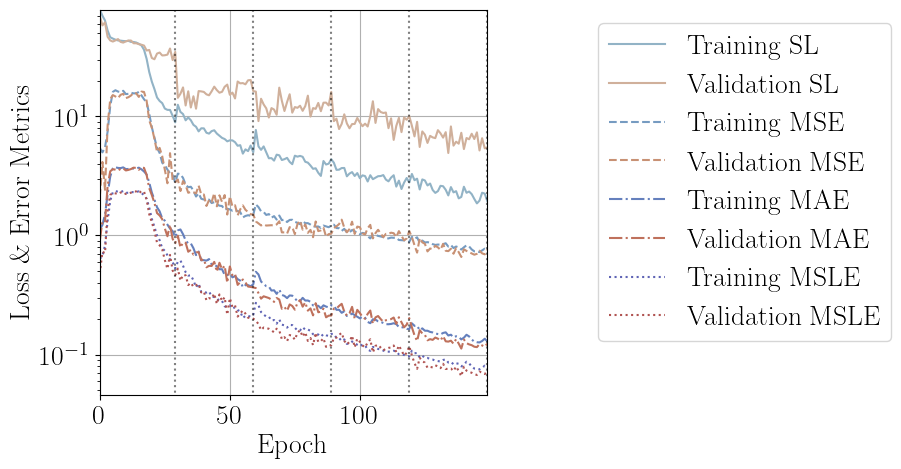

In [ ]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
# ax2 = ax1.twinx()

total_loss = np.concatenate([history.history['loss'] for history in histories])
total_val_loss = np.concatenate([history.history['val_loss'] for history in histories])
total_mse = np.concatenate([history.history['mean_squared_error'] for history in histories])
total_val_mse = np.concatenate([history.history['val_mean_squared_error'] for history in histories])
total_mae = np.concatenate([history.history['mean_absolute_error'] for history in histories])
total_val_mae = np.concatenate([history.history['val_mean_absolute_error'] for history in histories])
total_msle = np.concatenate([history.history['mean_squared_logarithmic_error'] for history in histories])
total_val_msle = np.concatenate([history.history['val_mean_squared_logarithmic_error'] for history in histories])
total_cosine = np.concatenate([history.history['cosine_similarity'] for history in histories])
total_val_cosine = np.concatenate([history.history['val_cosine_similarity'] for history in histories])
total_sparseLoss = np.concatenate([history.history['sparseLoss'] for history in histories])
total_val_sparseLoss = np.concatenate([history.history['val_sparseLoss'] for history in histories])
total_totalLoss = np.concatenate([history.history['totalLoss'] for history in histories])
total_val_totalLoss = np.concatenate([history.history['val_totalLoss'] for history in histories])
total_meanDistanceFromRecoToTrue = np.concatenate([history.history['meanDistanceFromRecoToTrue'] for history in histories])
total_val_meanDistanceFromRecoToTrue = np.concatenate([history.history['val_meanDistanceFromRecoToTrue'] for history in histories])
total_meanDistanceFromTrueToReco = np.concatenate([history.history['meanDistanceFromTrueToReco'] for history in histories])
total_val_meanDistanceFromTrueToReco = np.concatenate([history.history['val_meanDistanceFromTrueToReco'] for history in histories])
nEpochs = [len(history.history['loss']) for history in histories]

maxY = max(np.max(total_loss), np.max(total_val_loss))

ax1.plot(total_sparseLoss, label='Training SL', color=twilight[5,:])
ax1.plot(total_val_sparseLoss, label='Validation SL', color=twilight[40-5,:])

ax1.plot(total_mse, label='Training MSE', color=twilight[7,:], linestyle='--')
ax1.plot(total_val_mse, label='Validation MSE', color=twilight[40-7,:] , linestyle='--')

ax1.plot(total_mae, label='Training MAE', color=twilight[9,:], linestyle='-.')
ax1.plot(total_val_mae, label='Validation MAE', color=twilight[40-9,:], linestyle='-.')

ax1.plot(total_msle, label='Training MSLE', color=twilight[11,:], linestyle=':')
ax1.plot(total_val_msle, label='Validation MSLE', color=twilight[40-11,:], linestyle=':')

# ax1.plot(total_cosine, label='Training Cosine', color=twilight[13,:], linestyle='-.')
# ax1.plot(total_val_cosine, label='Validation Cosine', color=twilight[40-13,:], linestyle='-.')

# ax1.plot(total_meanDistanceFromRecoToTrue, label=r'Training Reco $\to$ True', color=twilight[15,:], linestyle='--')
# ax1.plot(total_val_meanDistanceFromRecoToTrue, label=r'Validation Reco $\to$ True', color=twilight[40-15,:], linestyle='--')

# ax1.plot(total_meanDistanceFromTrueToReco, label=r'Training True $\to$ Reco', color=twilight[17,:], linestyle='-.')
# ax1.plot(total_val_meanDistanceFromTrueToReco, label=r'Validation True $\to$ Reco', color=twilight[40-17,:], linestyle='-.')

ax1.vlines(np.cumsum(nEpochs)-1, 0, maxY, color='k', linestyle=':', alpha=0.5)

# ax2.plot(history.history['accuracy'], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')
# ax1.plot([], [], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax1.plot([], [], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')

ax1.set_xlabel('Epoch')

ax1.set_ylabel(r'Loss \& Error Metrics')
# ax2.set_ylabel('Accuracy Metrics')

ax1.set_yscale('log')
# ax2.set_yscale('log')

ax1.set_xlim(0, len(total_loss)-1)
# ax2.set_xlim(0, len(history.history['loss'])-1)
ax1.set_ylim(0, maxY)
# ax2.set_ylim(ymin=0, ymax=1)

ax1.grid()
# ax2.grid()

# ax1.set_title('Training history')
ax1.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.savefig('../figures/training.pdf', bbox_inches='tight')
plt.show()

In [ ]:
saveModel = False
loadModel = False
saveHistory = False
loadHistory = False

# fileName = 'models/model_{}_{}.h5'.format(plotRecoName, {True:'withErrors', False:'noErrors'}[makeErrors])
fileName = 'models/model_200multievent_20x20x20_5kFold_30epochs_primaryLabels_updatedLabels.h5'
if saveModel:
    model.save(fileName)
    print('Saved model to', fileName)
if loadModel:
    meanDistanceToTrueFromReco = meanDistanceFromRecoToTrue
    meanDistanceToRecoFromTrue = meanDistanceFromTrueToReco
    # model = tf.keras.models.load_model(fileName, custom_objects={'sparseLoss': sparseLoss, 
    #                                                              'meanDistanceFromRecoToTrue': meanDistanceFromRecoToTrue,
    #                                                              'meanDistanceFromTrueToReco': meanDistanceFromTrueToReco})
    model = tf.keras.models.load_model(fileName, custom_objects={'sparseLoss': sparseLoss,
                                                                 'meanDistanceToTrueFromReco': meanDistanceToTrueFromReco,
                                                                 'meanDistanceToRecoFromTrue': meanDistanceToRecoFromTrue})
    print('Loaded model from', fileName)
if saveHistory:
    historiesSave = []
    for history in histories:
        historiesSave.append({key: history.history[key] for key in history.history.keys()})
    with open(fileName.split('.')[0]+'_history.pkl', 'wb') as file_pi:
        pkl.dump(historiesSave, file_pi)
if loadHistory:
    with open(fileName.split('.')[0]+'_history.pkl', 'rb') as file_pi:
        historiesLoad = pkl.load(file_pi)

100%|██████████| 165/165 [00:13<00:00, 12.43it/s]


(7,)
[  0.      121.        0.        0.      171.11984 121.      121.     ]
(9,)
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


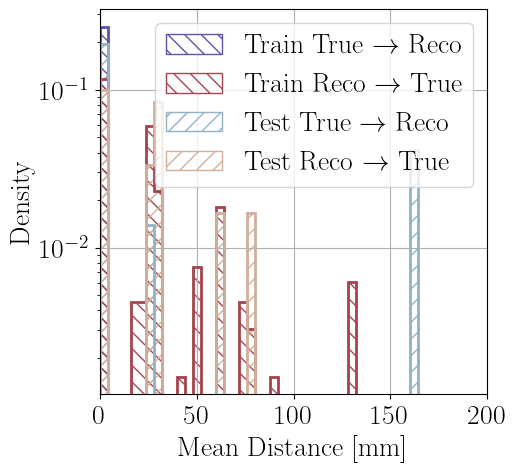

In [ ]:
nBins = 50
xmax = 200
# xmax = None
lw = 2
colors = [twilight[5,:], twilight[40-5,:], twilight[12,:], twilight[40-12,:]]
density = True
plots = [True, False]
epsInit = 15
optimize = True
minEntries = 15
deltaEps = 0.1

meanDistanceFromTrueToReco_test = []
meanDistanceFromRecoToTrue_test = []
meanDistanceFromTrueToReco_train = []
meanDistanceFromRecoToTrue_train = []
distancesFromTrueToReco_test = []
distancesFromRecoToTrue_test = []
distancesFromTrueToReco_train = []
distancesFromRecoToTrue_train = []

for i in tqdm.tqdm(range(len(X_test))):
    mean, distances = meanAndDistancesFromTrueToReco(Y_test[i], model.predict(X_test[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    meanDistanceFromTrueToReco_test.append(mean)
    distancesFromTrueToReco_test.append(distances.numpy())

    mean, distances = meanAndDistancesFromRecoToTrue(Y_test[i], model.predict(X_test[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    meanDistanceFromRecoToTrue_test.append(mean)
    distancesFromRecoToTrue_test.append(distances.numpy())
for i in tqdm.tqdm(range(len(X_train))):
    mean, distances = meanAndDistancesFromTrueToReco(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    meanDistanceFromTrueToReco_train.append(mean)
    distancesFromTrueToReco_train.append(distances.numpy())

    mean, distances = meanAndDistancesFromRecoToTrue(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    meanDistanceFromRecoToTrue_train.append(mean)
    distancesFromRecoToTrue_train.append(distances.numpy())

print(distancesFromRecoToTrue_test[0].shape)
print(distancesFromRecoToTrue_test[0])
print(distancesFromTrueToReco_test[0].shape)
print(distancesFromTrueToReco_test[0])

meanDistanceFromTrueToReco_test = np.array(meanDistanceFromTrueToReco_test)
meanDistanceFromRecoToTrue_test = np.array(meanDistanceFromRecoToTrue_test)
meanDistanceFromTrueToReco_train = np.array(meanDistanceFromTrueToReco_train)
meanDistanceFromRecoToTrue_train = np.array(meanDistanceFromRecoToTrue_train)

meanDistanceFromTrueToReco_test = meanDistanceFromTrueToReco_test[~np.isnan(meanDistanceFromTrueToReco_test)]
meanDistanceFromRecoToTrue_test = meanDistanceFromRecoToTrue_test[~np.isnan(meanDistanceFromRecoToTrue_test)]
meanDistanceFromTrueToReco_train = meanDistanceFromTrueToReco_train[~np.isnan(meanDistanceFromTrueToReco_train)]
meanDistanceFromRecoToTrue_train = meanDistanceFromRecoToTrue_train[~np.isnan(meanDistanceFromRecoToTrue_train)]

for i in range(len(distancesFromRecoToTrue_test)):
    distancesFromRecoToTrue_test[i] = distancesFromRecoToTrue_test[i][~np.isnan(distancesFromRecoToTrue_test[i])]
for i in range(len(distancesFromTrueToReco_test)):
    distancesFromTrueToReco_test[i] = distancesFromTrueToReco_test[i][~np.isnan(distancesFromTrueToReco_test[i])]
for i in range(len(distancesFromRecoToTrue_train)):
    distancesFromRecoToTrue_train[i] = distancesFromRecoToTrue_train[i][~np.isnan(distancesFromRecoToTrue_train[i])]
for i in range(len(distancesFromTrueToReco_train)):
    distancesFromTrueToReco_train[i] = distancesFromTrueToReco_train[i][~np.isnan(distancesFromTrueToReco_train[i])]

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[0] and plots[1]:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
elif plots[0] or plots[1]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax, ax]

if plots[0]:
    if xmax is None:
        xmax = np.max([np.max(meanDistanceFromRecoToTrue_test), np.max(meanDistanceFromTrueToReco_test), np.max(meanDistanceFromTrueToReco_train), np.max(meanDistanceFromTrueToReco_train)])


    bins_TR_train, edges_TR_train, _ = ax[0].hist(meanDistanceFromTrueToReco_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[0].hist(meanDistanceFromRecoToTrue_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[0].hist(meanDistanceFromTrueToReco_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[0].hist(meanDistanceFromRecoToTrue_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test Reco $\to$ True')

    ax[0].add_patch(patch_TR_train)
    ax[0].add_patch(patch_RT_train)
    ax[0].add_patch(patch_TR_test)
    ax[0].add_patch(patch_RT_test)

    ax[0].set_yscale('log')
    ax[0].set_xlabel('Mean Distance [mm]')
    ax[0].set_ylabel('Density')
    ax[0].set_xlim(0, xmax)
    ax[0].legend()
    ax[0].grid()

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[1]:
    if xmax is None:
        xmax = np.max([np.max(np.concatenate(distancesFromRecoToTrue_train)), np.max(np.concatenate(distancesFromTrueToReco_train)), np.max(np.concatenate(distancesFromRecoToTrue_test)), np.max(np.concatenate(distancesFromTrueToReco_test))])

    bins_TR_train, edges_TR_train, _ = ax[1].hist(np.concatenate(distancesFromTrueToReco_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[1].hist(np.concatenate(distancesFromRecoToTrue_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[1].hist(np.concatenate(distancesFromTrueToReco_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[1].hist(np.concatenate(distancesFromRecoToTrue_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train: True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train: Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test: True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test: Reco $\to$ True')

    ax[1].add_patch(patch_TR_train)
    ax[1].add_patch(patch_RT_train)
    ax[1].add_patch(patch_TR_test)
    ax[1].add_patch(patch_RT_test)

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Distance [mm]')
    ax[1].set_ylabel('Density')
    ax[1].set_xlim(0, xmax)
    ax[1].legend()
    ax[1].grid()

plt.savefig('../figures/meanDistances.pdf', bbox_inches='tight')
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_62470/4165574376.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[ind//nCols, ind%nCols].scatter(primaryTrue[:,0]/scale,
  5%|▌         | 1/20 [00:00<00:03,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 2/20 [00:00<00:02,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 3/20 [00:00<00:02,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 4/20 [00:00<00:02,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 5/20 [00:00<00:02,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 6/20 [00:00<00:02,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 7/20 [00:01<00:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 8/20 [00:01<00:02,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 9/20 [00:01<00:01,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 10/20 [00:01<00:01,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 11/20 [00:01<00:01,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 12/20 [00:02<00:01,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 13/20 [00:02<00:01,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 14/20 [00:02<00:00,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 15/20 [00:02<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 16/20 [00:02<00:00,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 17/20 [00:02<00:00,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 18/20 [00:02<00:00,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 19/20 [00:03<00:00,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_62470/4165574376.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


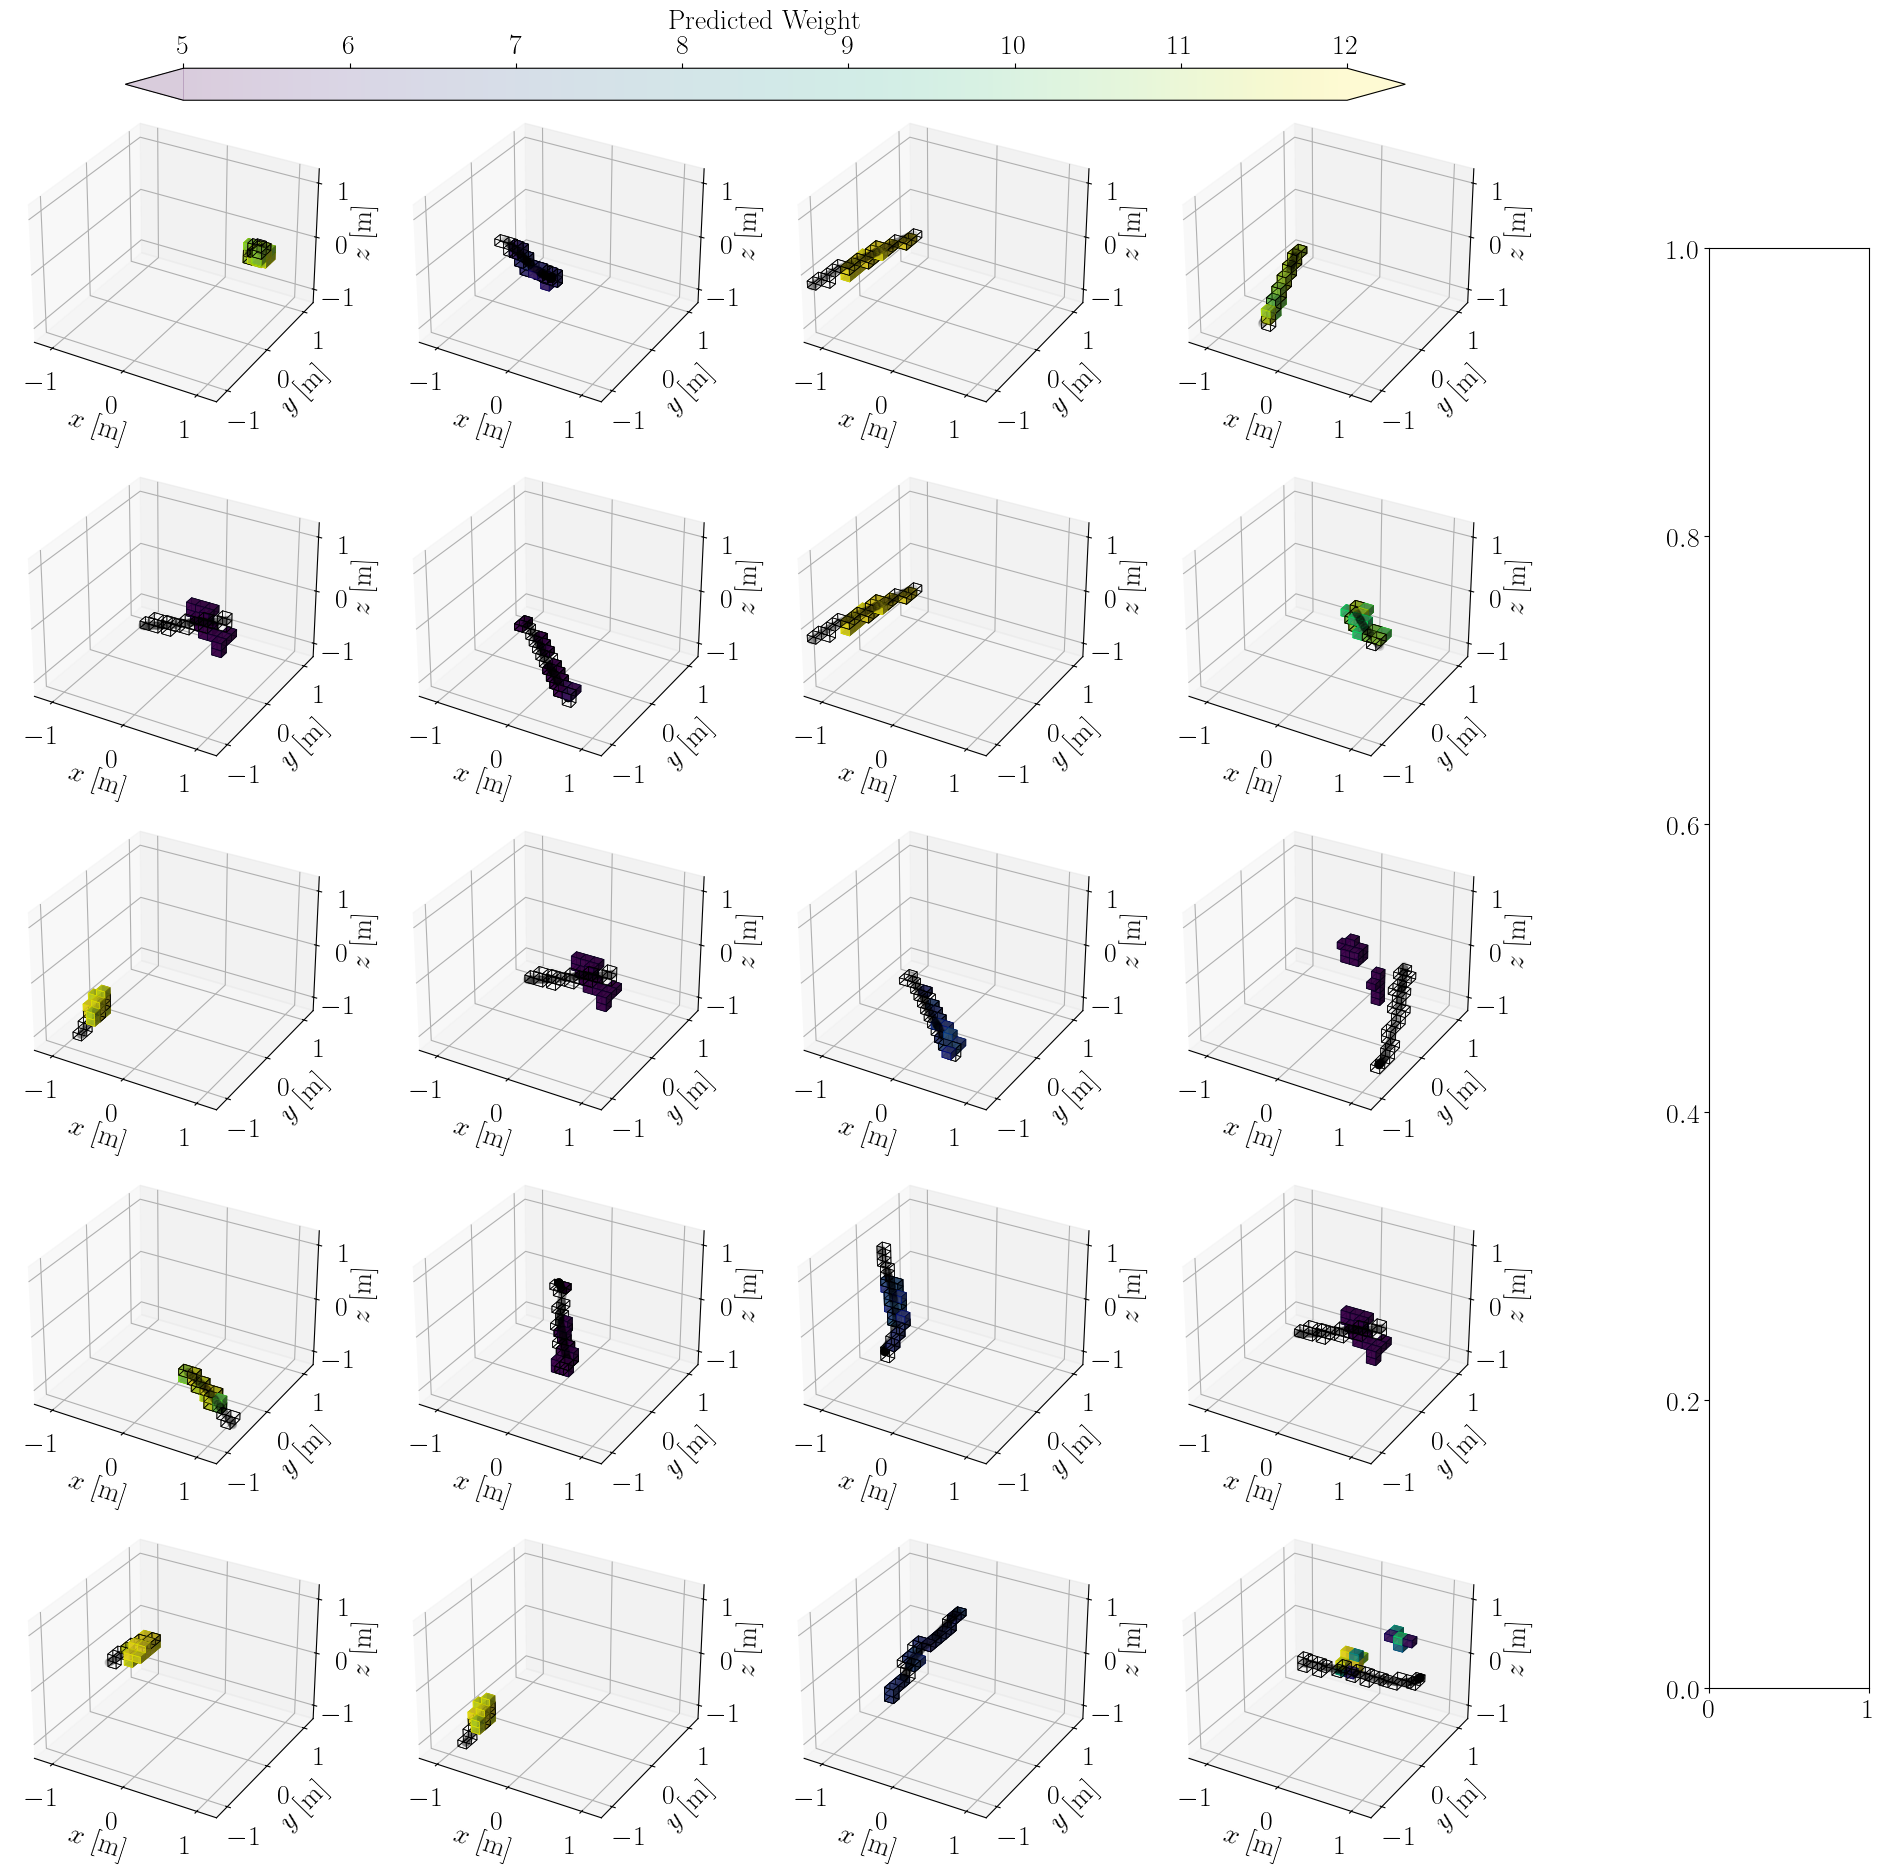

In [ ]:
# %matplotlib qt
%matplotlib inline

inds = range(len(X_test))
# inds = [2]
epsInit = 12 # 0.2
minNshown = 15

nCols = 4
nRows = 5
fig, axs = plt.subplots(nRows, nCols, figsize=(16, 18), subplot_kw={'projection': '3d'})

scale = 1000

globalColorNorm = cm.colors.Normalize(vmin=5, vmax=12)

xPlot, yPlot, xInd = X_test, Y_test, X_test_indices
# xPlot, yPlot, xInd = X_train, Y_train, X_train_indices

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale, gridSize[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale, gridSize[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale, gridSize[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

for ind in tqdm.tqdm(inds):
    trueGrid = yPlot[ind]
    # trueGrid = zoom(Y_test[ind], [
    #     gridSize_input[0]/gridSize_output[0], 
    #     gridSize_input[1]/gridSize_output[1], 
    #     gridSize_input[2]/gridSize_output[2]])
    predGrid = model.predict(xPlot[ind].reshape(1, 
                                            gridSize_input[0], 
                                            gridSize_input[1], 
                                            gridSize_input[2], 
                                            6)).reshape(gridSize_output)
    # predGrid = zoom(predGrid, [
    #     gridSize_input[0]/gridSize_output[0], 
    #     gridSize_input[1]/gridSize_output[1], 
    #     gridSize_input[2]/gridSize_output[2]])
    # truePos = np.array(dfs_hits[ind]['initialPosition'].to_list())

    eps = epsInit
    while True:
        nonZeroInd = np.where(predGrid.flatten()>eps)
        if len(nonZeroInd[0]) >= minNshown:
            break
        elif eps < 0:
            break
        eps -= 0.1

    # scatter = axs[ind//nCols, ind%nCols].scatter(grid_pos[nonZeroInd,0]/scale, 
    #                                              grid_pos[nonZeroInd,1]/scale, 
    #                                              grid_pos[nonZeroInd,2]/scale, 
    #                                              c=predGrid.flatten()[nonZeroInd], cmap=cm.viridis, s=100, alpha=0.2, marker='s', norm=globalColorNorm)
    colors = cm.viridis(globalColorNorm(predGrid))
    voxels = axs[ind//nCols, ind%nCols].voxels(xEdges,
                                               yEdges,
                                               zEdges,
                                               predGrid>eps,
                                               facecolors=colors,
                                               edgecolors=np.clip(colors*2-0.5, 0, 1),
                                               linewidth=0.5,
                                               alpha=0.8)
    # plt.colorbar(scatter)
    
    # nonZeroInd = np.where(trueGrid.flatten()>0)
    # axs[ind//nCols, ind%nCols].scatter(grid_pos[nonZeroInd,0]/scale, 
    #                                    grid_pos[nonZeroInd,1]/scale, 
    #                                    grid_pos[nonZeroInd,2]/scale, c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')
    axs[ind//nCols, ind%nCols].voxels(xEdges,
                                      yEdges,
                                      zEdges,
                                      trueGrid>0,
                                      facecolors='k',
                                      edgecolors='k',
                                      linewidth=0.5,
                                      alpha=0.0)
    primaryTrue = np.array(dfs_primary[xInd[ind]]['position'].to_list())
    axs[ind//nCols, ind%nCols].scatter(primaryTrue[:,0]/scale,
                                       primaryTrue[:,1]/scale,
                                       primaryTrue[:,2]/scale,
                                       c='k', cmap=cm.viridis, s=30, alpha=0.1)

    # ax.scatter(truePos[:,0], truePos[:,1], truePos[:,2], c='g', cmap=cm.viridis, s=100, alpha=1)

    axs[ind//nCols, ind%nCols].set_xlim(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale)
    axs[ind//nCols, ind%nCols].set_ylim(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale)
    axs[ind//nCols, ind%nCols].set_zlim(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale)

    axs[ind//nCols, ind%nCols].set_xlabel(r'$x$ [m]', labelpad=7)
    axs[ind//nCols, ind%nCols].set_ylabel(r'$y$ [m]')
    axs[ind//nCols, ind%nCols].set_zlabel(r'$z$ [m]', labelpad=0)

axNew = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axNew.set_visible(False)
cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=axNew, orientation='horizontal', label='Predicted Weight', alpha=0.2, pad=0.1, aspect=40, shrink=0.8, extend='both')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_position([0.11, 0.1, 0.8, 0.9])

axExtend = fig.add_axes([1.1, 0.1, 0.1, 0.8])
axExtend.set_visible(True)

fig.tight_layout()
plt.savefig('../figures/allTestEvents.pdf', bbox_inches='tight')
plt.show()